# Overview

According to the [homepage](https://mlflow.org/) MLFlow is "An open source platform for the machine learning lifecycle". Its intended purpose is to provide a single tool which allows data scientists to address ML specific components of the Software Development Life cycle (SDLC) including: experimentation, reproducibility, model deployment, and a model storage in a centralizing model registry.

The project breaks down into the following sub-components:
- MLflow Tracking - Allows user to record and query experiments: code, data, config, and results
- MLflow Projects - A standard package format allowing reproducable deployments of models to any platform regardless of where they were authored
- MLflow Models - A unified abstraction layer allowing support for integration with multiple machine learning model libraries and providers
- Model Registry - Store, annotate, discover, and manage models in a central repository

We will see that each sub-component has a coresponding UI and API.

The project page boasts integrations with many big name players, providers, and technology stacks and sees contributions coming from many big names in the space.

## Agenda

In this notebook we will get our feet wet and explore the basic functionalities. For official documentation, see the [MLFlow quickstart guide](https://mlflow.org/docs/latest/quickstart.html).



# 1. MLFlow Architecture

Before we get started with MLFlow, It is important to understand the architectural components. As we will see in section 2, there are a number of ways to deploy the MLFlow. Before we choose a method, it is important to understand that an MLFlow deployment consists of the following components:
- Backend - Persists MLflow entities (runs, parameters, metrics, tags, notes, metadata, etc)
- Artifact Store - persists artifacts (files, models, images, in-memory objects, or model summary, etc)
- REST API - The optional component exposing web based MLFlow API
- Tracking UI - The Web UI for lets you visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools, and register or tag models.



# 2. Deployment Options

Reading through the [documentation](https://mlflow.org/docs/latest/tracking.html), assuming you are deploying your own MLFlow installation, you have the following documented options:

<table >
	<tbody>
		<tr>
			<td>Scenario</td>
			<td>Description</td>
			<td>Backend</td>
			<td>Artifact Store</td>
		</tr>
		<tr>
			<td>1</td>
			<td>MLflow on localhost</td>
			<td>local ./mlruns&nbsp;directory</td>
			<td>local ./mlruns&nbsp;directory</td>
		</tr>
		<tr>
			<td>2</td>
			<td>MLflow on localhost with SQLite</td>
			<td>local ./mlruns directory</td>
			<td>local mlruns.db file</td>
		</tr>
		<tr>
			<td>3</td>
			<td>MLflow on localhost with Tracking Server</td>
			<td>A REST API utilizes&nbsp;./mlruns directory</td>
			<td>A REST API utilizes ./mlruns directory</td>
		</tr>
		<tr>
			<td>4</td>
			<td>MLflow with remote Tracking Server, backend and artifact stores</td>
			<td>A REST API utilizes remote backend</td>
			<td>A REST API utilizes remote artifact store</td>
		</tr>
	</tbody>
</table>

**Note**: None of these options discuss the MLFlow UI.

Databricks and AWS also provide MLFlow deployments that data scientists can leverage.

For our purposes, we will keep it simple and go with scenario 1 and host our own UI.

# 3. MLFLow Object Model

# 4. Launching MLFlow
Launching MLFlow from a jupyter notebook is a bit complicated. Long story short; we will need to launch the process in a separate thread so that the jupyter cell does not block us by running forever.

In [21]:
shell_command = "mlflow ui"
mlflow_port = 5000

def mlflow_running():
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        running = s.connect_ex(('localhost', mlflow_port)) == 0
        return running
    
if mlflow_running():
    print("It looks like MLFlow is already running. Check is python.exe is listening on port 5000 ")
else:
    print("Starting MLFlow")
    import subprocess
    process = subprocess.Popen(shell_command)
print("MLFlow should be accessible at http://localhost:5000")

It looks like MLFlow is already running. Check is python.exe is listening on port 5000 
MLFlow should be accessible at http://localhost:5000


Once launched, you should see a page like this:

<center><img src="images/mlflow_ui.png" ></center>

We will also notice that the mlruns directory will be created for us in the same directory as our notebook

In [215]:
! dir

 Volume in drive C has no label.
 Volume Serial Number is A4C8-EE27

 Directory of C:\Users\Administrator\git\ml-training-jupyter-notebooks\Machine Learning\MLOps

06/14/2021  09:07 AM    <DIR>          .
06/14/2021  09:07 AM    <DIR>          ..
06/11/2021  05:40 PM    <DIR>          .ipynb_checkpoints
06/12/2021  11:03 AM    <DIR>          images
06/14/2021  09:07 AM            78,162 Intro To MLFlow.ipynb
06/12/2021  11:56 AM    <DIR>          mlruns
06/11/2021  05:40 PM             1,266 README.md
               2 File(s)         79,428 bytes
               5 Dir(s)   1,480,425,472 bytes free


# 5. Example Workflow
## 5.1. Load Data
In our example we will load some NASDAQ data and train a model to make predictions. 

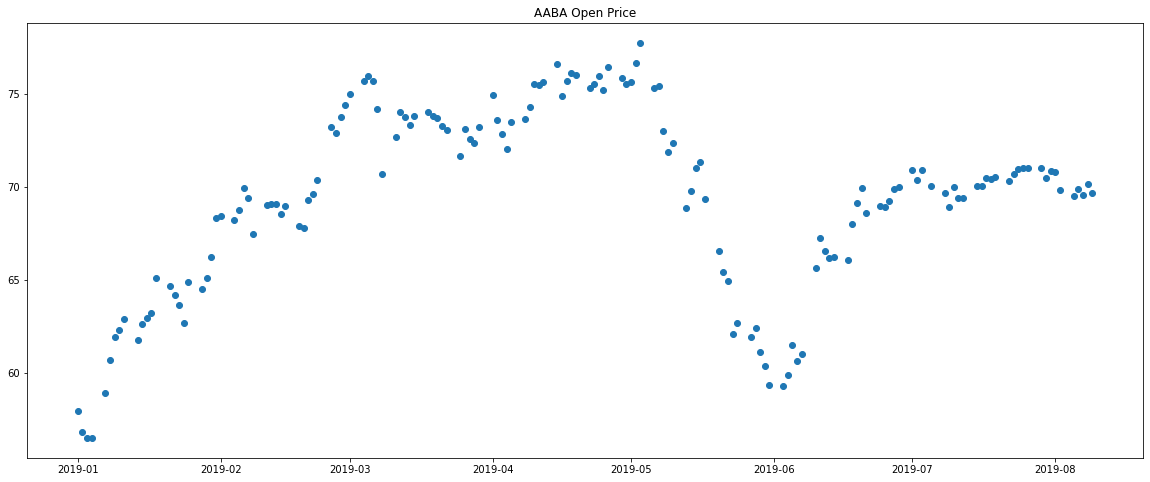

In [81]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../../Utilities/utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

# Read the file into a dataframe
file_path = "../../Example Data Sets/nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
import pandas
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)
aaba_dataframe = pandas_dataframe[pandas_dataframe["ticker"] == 'AABA']
aaba_dataframe = aaba_dataframe.sort_values(by="date", ascending=True)

# Plot the data
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots(figsize=(20, 8), nrows=1, ncols=1)
ax.set_title("AABA Open Price")
pyplot.scatter(aaba_dataframe["date"], aaba_dataframe["open"]);

## 5.2. Train The ARIMA Model

The model we will be using is the ARIMA model which stands for:

- AutoRegressive (AR) - the model takes advantage of the connection between a predefined number of lagged observations and the current one.
- Integrated (I) - differencing between raw observations (eg. subtracting observations at different time steps).
- Moving Average (MA) - the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q):
- p - number of lag observations
- d - the degree of differencing
- q - the size of the moving average window


In [48]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

We will then iterate through a number of training and testing scenarios choosing the best parameters for the predictions.

In [107]:
import itertools
import statsmodels.api

# Split the data into a train and test set
datapoint_count = aaba_dataframe.shape[0]
split_point = int(datapoint_count * 0.8)
train_df = aaba_dataframe[:split_point]
test_df = aaba_dataframe[split_point:]

# Generate the posisble parameters for the model
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

# Train the model
#      Find the optimal parameter set and the coresponding performance metric
#

best_param_set = None
best_perf_metric = -1

for pdq in pdq_combinations:
    
    # Create the model
    model = statsmodels.api.tsa.statespace.SARIMAX(
        train_df["open"], 
        order=pdq, 
        enforce_stationarity=True, 
        enforce_invertibility=True)
    
    # Fit the model to the data
    fit_model = model.fit()
    
    # Calculate performance metric
    aic = fit_model.aic
    
    # Record the results
    if aic < best_perf_metric or best_perf_metric == -1:
        best_param_set = pdq
        best_perf_metric = aic

    #print("The parameter set {} yielded an AIC of {}".format(pdq, aic))

print("The best parameter set {} yielded an AIC of {}".format(best_param_set, best_perf_metric))
fit_model.summary()

The best parameter set (0, 1, 0) yielded an AIC of 409.4944259259052


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                  126
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -202.800
Date:                Fri, 11 Jun 2021   AIC                            415.600
Time:                        22:26:31   BIC                            429.702
Sample:                             0   HQIC                           421.329
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8990      0.093     -9.686      0.000      -1.081      -0.717
ar.L2          0.0379      0.087      0.436      0.663      -0.133       0.208
ma.L1          0.0319     15.866      0.002      0.998     -31.066      31.130
ma.L2         -0.9680     15.372     -0.063      0.950     -31.097      29.161
sigma2         1.4904     23.588      0.063      0.950     -44.742      47.723
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.83
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.90   Skew:                            -0.00
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5.3. Test The Model
We can make predictions using our fit model:

In [159]:
# Make predictions using the fit model
points_to_predict = datapoint_count - split_point
points_to_predict
alpha = 0.05
predictions = fit_model.forecast(points_to_predict, alpha=alpha)  # 95% conf

# Calculate the upper and lower bound for the confidence interval
forecast = fit_model.get_forecast(points_to_predict)
ci = forecast.conf_int()

Plotting our predictions we see:

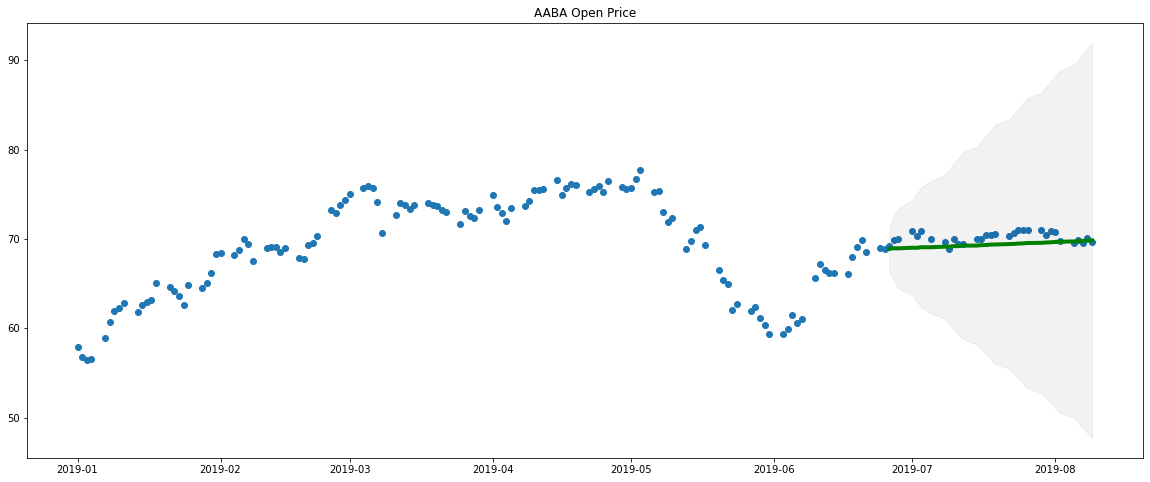

In [158]:
fig, ax = pyplot.subplots(figsize=(20, 8), nrows=1, ncols=1)
ax.set_title("AABA Open Price")
ax.scatter(aaba_dataframe["date"], aaba_dataframe["open"])
ax.plot(aaba_dataframe["date"][split_point:], predictions, color="green", linewidth=4);

lower_series= ci.iloc[:, 0]
upper_series= ci.iloc[:, 1]
ax.fill_between(aaba_dataframe["date"][split_point:], lower_series, upper_series, color='k', alpha=alpha);

We can quantify the error from our test trial:

In [177]:
import math
import numpy

y_actual = test_df["open"].to_numpy()
y_predicted = predictions

MSE = numpy.square(numpy.subtract(y_actual,y_predicted)).mean()
RMSE = math.sqrt(MSE)

print("The MSE is: {}".format(MSE))
print("The RMSE is: {}".format(RMSE))

The MSE is: 1.0199129847785446
The RMSE is: 1.0099074139635498


# 6. Configure MLFlow Connection
We need to tell our MLFlow client where the server is and how to connect.

In [179]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

We can verify the connection settings as follows:

In [183]:
mlflow.get_tracking_uri()

'http://127.0.0.1:5000'

In addition to the MLFLOW_TRACKING_URI environment variable, the following environment variables allow passing HTTP authentication to the tracking server:

- MLFLOW_TRACKING_USERNAME and MLFLOW_TRACKING_PASSWORD - username and password to use with HTTP Basic authentication. To use Basic authentication, you must set both environment variables .

- MLFLOW_TRACKING_TOKEN - token to use with HTTP Bearer authentication. Basic authentication takes precedence if set.

- MLFLOW_TRACKING_INSECURE_TLS - If set to the literal true, MLflow does not verify the TLS connection, meaning it does not validate certificates or hostnames for https:// tracking URIs. This flag is not recommended for production environments. If this is set to true then MLFLOW_TRACKING_SERVER_CERT_PATH must not be set.

- MLFLOW_TRACKING_SERVER_CERT_PATH - Path to a CA bundle to use. Sets the verify param of the requests.request function (see requests main interface). When you use a self-signed server certificate you can use this to verify it on client side. If this is set MLFLOW_TRACKING_INSECURE_TLS must not be set (false).

- MLFLOW_TRACKING_CLIENT_CERT_PATH - Path to ssl client cert file (.pem). Sets the cert param of the requests.request function (see requests main interface). This can be used to use a (self-signed) client certificate.

https://www.mlflow.org/docs/latest/tracking.html

# 7. Conduct An Experiment

Usint the MLFLow Tracking API we are able to log model paramters, metics, and artifacts to the MLFlow server.

The first thing we need to do is tell MLFlow which experiment we are working on

## 7.1. Create The Experiment Object
The experiment object allows us logically group runs which serve a common task. In our case, the act of training the model, testing the model, and calculating performance metrics can all be considered a run. The larger experiment is thus observing the different runs so that we can choose the best performing model parameters.

As MLFlow is operating on a distributed model, we have the ability to attach to existing experiments or define new ones. Before creating one, we will observe that there is a default experiment which is automagically created for us.

In [194]:
from  mlflow.tracking import MlflowClient
mlflow_client = MlflowClient()
experiments = mlflow_client.list_experiments()
experiments

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

We will create a different experiment to store information from our runs. We will name the experiment AABA-ARIMA

In [314]:
experiment_name = 'AABA-ARIMA'
mlflow.set_experiment(experiment_name)

INFO: 'AABA-ARIMA' does not exist. Creating a new experiment


In [315]:
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='AABA-ARIMA', tags={}>

In [316]:
mlflow_client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='AABA-ARIMA', tags={}>]

We will see that a directory is created inside the mlruns directory on our local machine.

Looking at the MLFlow UI, we see that a new experiment appears:

<center><img src="images/experiments.png" style="width: 500px"></center>

## 7.2. Conduct The Experiment And Log Results To ML Flow
We are now going to repeat the example workflow we saw in section #5. With two main differences, the first is that we will be logging information to MLFlow, the second is that we will be querying the results from MLFlow rather (section 8) than keeping track locally.

In this section we conduct multiple runs (one for each hyperparameter set). For each run we will log the trained model, the parameters, the performance metric, and a chart created from the testing phase of our run.

In [303]:
import statsmodels.api

# Create function to train the model
def train_SARIMAX_model(pdq, x):

    # Create the model
    model = statsmodels.api.tsa.statespace.SARIMAX(
        x, 
        order=pdq, 
        enforce_stationarity=True, 
        enforce_invertibility=True)
    
    # Fit the model to the data
    trained_model = model.fit()
    
    # Calculate performance metric
    aic = trained_model.aic
    
    return trained_model, aic

In [304]:
def train_SARIMAX_model_and_log_to_mlflow(pdq, x):
    
    # Log the model parameters on mlflow
    mlflow.log_params({
        "p": pdq[0],
        "d" :pdq[1],
        "q": pdq[2]
    })    

    # Train the model
    trained_model, aic = train_SARIMAX_model(pdq, x)

    # Log the model in mlflow
    mlflow.sklearn.log_model(trained_model, artifact_path=run_name)

    # Log metrics
    mlflow.log_metrics({
        "aic": aic
    })

    return trained_model, aic

In [305]:
# Make predictions using the fit model
def test_SARIMAX_model(trained_model, points_to_predict, alpha):
    
    points_to_predict = datapoint_count - split_point
    points_to_predict
    alpha = 0.05
    predictions = trained_model.forecast(points_to_predict, alpha=alpha)  # 95% conf

    # Calculate the upper and lower bound for the confidence interval
    forecast = trained_model.get_forecast(points_to_predict)   
    
    return forecast

In [322]:
import matplotlib.pyplot as pyplot

# Turn off interactive mode so our figures are not displayed
# We will be writing them to a file and uploading them to mlflow instead
pyplot.ioff()

def plot_predictions(forecast):

        return fig    

In [350]:
# Turn off interactive mode so our figures are not displayed
#      We will be writing them to a file and uploading them to mlflow instead
import matplotlib.pyplot as pyplot
pyplot.ioff()

# Generate the posisble parameters for the model
import itertools
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

# Train and test the model
for pdq in pdq_combinations:

    # Create an MLFlow run
    run_name = "SARIMAX-{}_{}_{}".format(*list(pdq))
    tags = {"model_type": "SARIMAX"}
    with mlflow.start_run(run_name=run_name, tags=tags) as mlflow_run:
    
        # Train the model
        x = train_df["open"]
        trained_model, aic = train_SARIMAX_model_and_log_to_mlflow(pdq, x)

        # Test the model
        alpha = 0.05
        forecast = test_SARIMAX_model(trained_model, points_to_predict, alpha)

        # Draw a plot        
        ci = forecast.conf_int()
        lower_series= ci.iloc[:, 0]
        upper_series= ci.iloc[:, 1]
        fig, ax = pyplot.subplots(figsize=(20, 8), nrows=1, ncols=1)
        ax.set_title("AABA Open Price")
        ax.scatter(aaba_dataframe["date"], aaba_dataframe["open"])
        ax.plot(aaba_dataframe["date"][split_point:], predictions, color="green", linewidth=4);
        ax.fill_between(aaba_dataframe["date"][split_point:], lower_series, upper_series, color='k', alpha=alpha);
        pyplot.close(fig)

        # Save the plot to the run
        file_name = "test_results.png"
        fig.savefig(file_name)
        mlflow.log_artifact(file_name)

print("All runs complete!")

All runs complete!


In [ ]:
    # Register the model
    #model_name = run_name
    #model_uri = "runs:/{}/{}".format(mlflow_run.info.run_id, run_name)
    #mv = mlflow.register_model(model_uri, model_name)  

# 8. Retrieve And Query Results
Now that the experiment is complete was have the ability to query the results From MLFlow. 

We saw previously that we can keep track of results locally but this is not ideal when we are executing workloads on distributed compute systems (like Apache Spark). Additionally, we may not be interested in the results once they are ready. Instead we may only be interested later on as part of some larger information gathering process. For example, choosing the best model out of several experiments.

## 8.1. Retrieve Result Set
In the code snippets below we can retrieve all experiment run data from MLFlow. This information is presented as a pandas dataframe. As we will see, this means all of our pandas (and posisbly koalas/spark-sql) functionality is available.

In [365]:
# Get the experiment ID
print("Searching for experiment named '{}'".format(experiment_name))
experiment = [experiment for experiment in mlflow_client.list_experiments() if experiment.name == experiment_name][0]
print("Found id: {}".format(experiment.experiment_id))

# Get the runs for the experiment
print("Getting the run information")
experiment_run_df = mlflow.search_runs()
run_count = experiment_run_df.shape[0]
print("Found {} runs".format(run_count))

Searching for experiment named 'AABA-ARIMA'
Found id: 1
Getting the run information
Found 27 runs


In [366]:
experiment_run_df.head(3)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.aic,params.d,params.p,params.q,tags.mlflow.source.name,tags.model_type,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user
0,d903701a21cf412b812c7ef21765cca9,1,FINISHED,./mlruns/1/d903701a21cf412b812c7ef21765cca9/ar...,2021-06-14 22:42:14.714000+00:00,2021-06-14 22:42:15.194000+00:00,415.600221,2,2,2,c:\program files\python36\lib\site-packages\ip...,SARIMAX,LOCAL,SARIMAX-2_2_2,"[{""run_id"": ""d903701a21cf412b812c7ef21765cca9""...",Administrator
1,f61bd36a2b294d9b8a203d6c957f4d01,1,FINISHED,./mlruns/1/f61bd36a2b294d9b8a203d6c957f4d01/ar...,2021-06-14 22:42:13.897000+00:00,2021-06-14 22:42:14.707000+00:00,415.726758,2,2,1,c:\program files\python36\lib\site-packages\ip...,SARIMAX,LOCAL,SARIMAX-2_2_1,"[{""run_id"": ""f61bd36a2b294d9b8a203d6c957f4d01""...",Administrator
2,99ee0233d2d44dbcba61206f4f69bcee,1,FINISHED,./mlruns/1/99ee0233d2d44dbcba61206f4f69bcee/ar...,2021-06-14 22:42:13.594000+00:00,2021-06-14 22:42:13.888000+00:00,441.743152,2,2,0,c:\program files\python36\lib\site-packages\ip...,SARIMAX,LOCAL,SARIMAX-2_2_0,"[{""run_id"": ""99ee0233d2d44dbcba61206f4f69bcee""...",Administrator


**Note**: MLFlow does provide the ability to submit query strings to the API. This is advantageous when we are working with a large amount of results. Rather than transfer all the data to the client, we can ask the server to do the hard work. We do not explore that functionality here but it is worth looking into for production type workflows. More information can be found in the [documentation for the search api](https://www.mlflow.org/docs/latest/search-syntax.html).

## 8.2. Query Run Data For Best Run
In our case we are looking for the model parameter set with the lowest AIC. We can query this information using basic pandas functionality:

In [367]:
min_aic = experiment_run_df["metrics.aic"].min()
best_run = experiment_run_df[experiment_run_df["metrics.aic"] == min_aic].iloc[0]
best_run

run_id                                            efecf188533c4e2ab87b55623e0d0671
experiment_id                                                                    1
status                                                                    FINISHED
artifact_uri                     ./mlruns/1/efecf188533c4e2ab87b55623e0d0671/ar...
start_time                                        2021-06-14 22:42:01.670000+00:00
end_time                                          2021-06-14 22:42:01.945000+00:00
metrics.aic                                                                409.494
params.d                                                                         1
params.p                                                                         0
params.q                                                                         0
tags.mlflow.source.name          c:\program files\python36\lib\site-packages\ip...
tags.model_type                                                            SARIMAX
tags

In [368]:
type(best_run)

pandas.core.series.Series

## 8.3. Download Run Artifacts
When artifacts are logged to the MLFlow server, they are logged to a single directory coresponding to that run. The python API provides a way to download that directory to our local machine. We will notice that the file names of logged artifacts are the same in MLFlow as they were in the 

The first thing we will do is create that local directory:

In [369]:
# Create the tmp dir to store our artifacts
local_dir = "tmp"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

Next we download the artifacts

In [370]:
# Download the artifacts
mlflow_client.download_artifacts(r'efecf188533c4e2ab87b55623e0d0671', "", "tmp")

'C:\\Users\\Administrator\\git\\ml-training-jupyter-notebooks\\Machine Learning\\MLOps\\tmp\\'

We can show the files inside the tmp folder to confirm something was downloaded. Notice that the artifact names are preserved. We also see a folder named after the run which contains the default artifacts (picklefile, condafile, mlmodel file).

In [371]:
! dir tmp

 Volume in drive C has no label.
 Volume Serial Number is A4C8-EE27

 Directory of C:\Users\Administrator\git\ml-training-jupyter-notebooks\Machine Learning\MLOps\tmp

06/14/2021  05:54 PM    <DIR>          .
06/14/2021  05:54 PM    <DIR>          ..
06/14/2021  05:54 PM    <DIR>          SARIMAX-0_1_0
06/14/2021  05:54 PM            24,477 test_results.png
               1 File(s)         24,477 bytes
               3 Dir(s)   1,319,653,376 bytes free


We can load the chart stored in the artifact using a multitude of libraries.

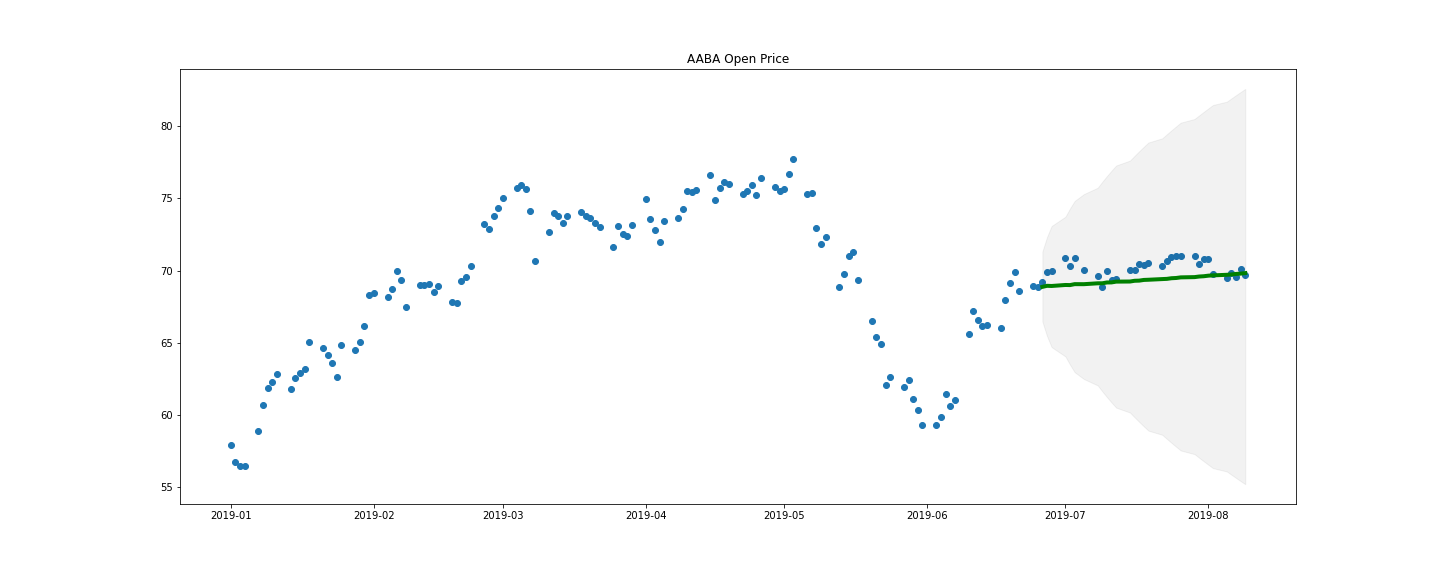

In [419]:
from IPython.display import Image
local_image_path = "tmp/test_results.png"
Image(local_image_path)